In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [2]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [3]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2344.000000,2344.000000,2.344000e+03,2344.000000,2.344000e+03,2344.000000,2.344000e+03,2.344000e+03
mean,7548.350621,-0.990424,-5.895742e-07,-0.000168,-4.952150e-07,-0.000011,2.453067e-07,1.729460e-08
std,4349.693426,0.001021,3.212275e-03,0.000715,2.139333e-03,0.006607,1.474166e-03,2.512213e-08
min,19.280590,-0.991668,-4.523862e-03,-0.001139,-3.247579e-03,-0.009040,-2.084719e-03,-2.785758e-08
25%,3783.815250,-0.991459,-3.224401e-03,-0.000878,-1.993437e-03,-0.006529,-1.487002e-03,-2.321468e-09
50%,7548.350500,-0.990587,-1.529082e-05,-0.000219,-5.756147e-06,-0.000394,6.194265e-06,1.033334e-08
75%,11312.887500,-0.989400,3.228971e-03,0.000540,1.972725e-03,0.006461,1.480479e-03,3.709943e-08
max,15077.420000,-0.988843,4.523994e-03,0.000913,3.247771e-03,0.009939,2.084456e-03,7.822104e-08


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

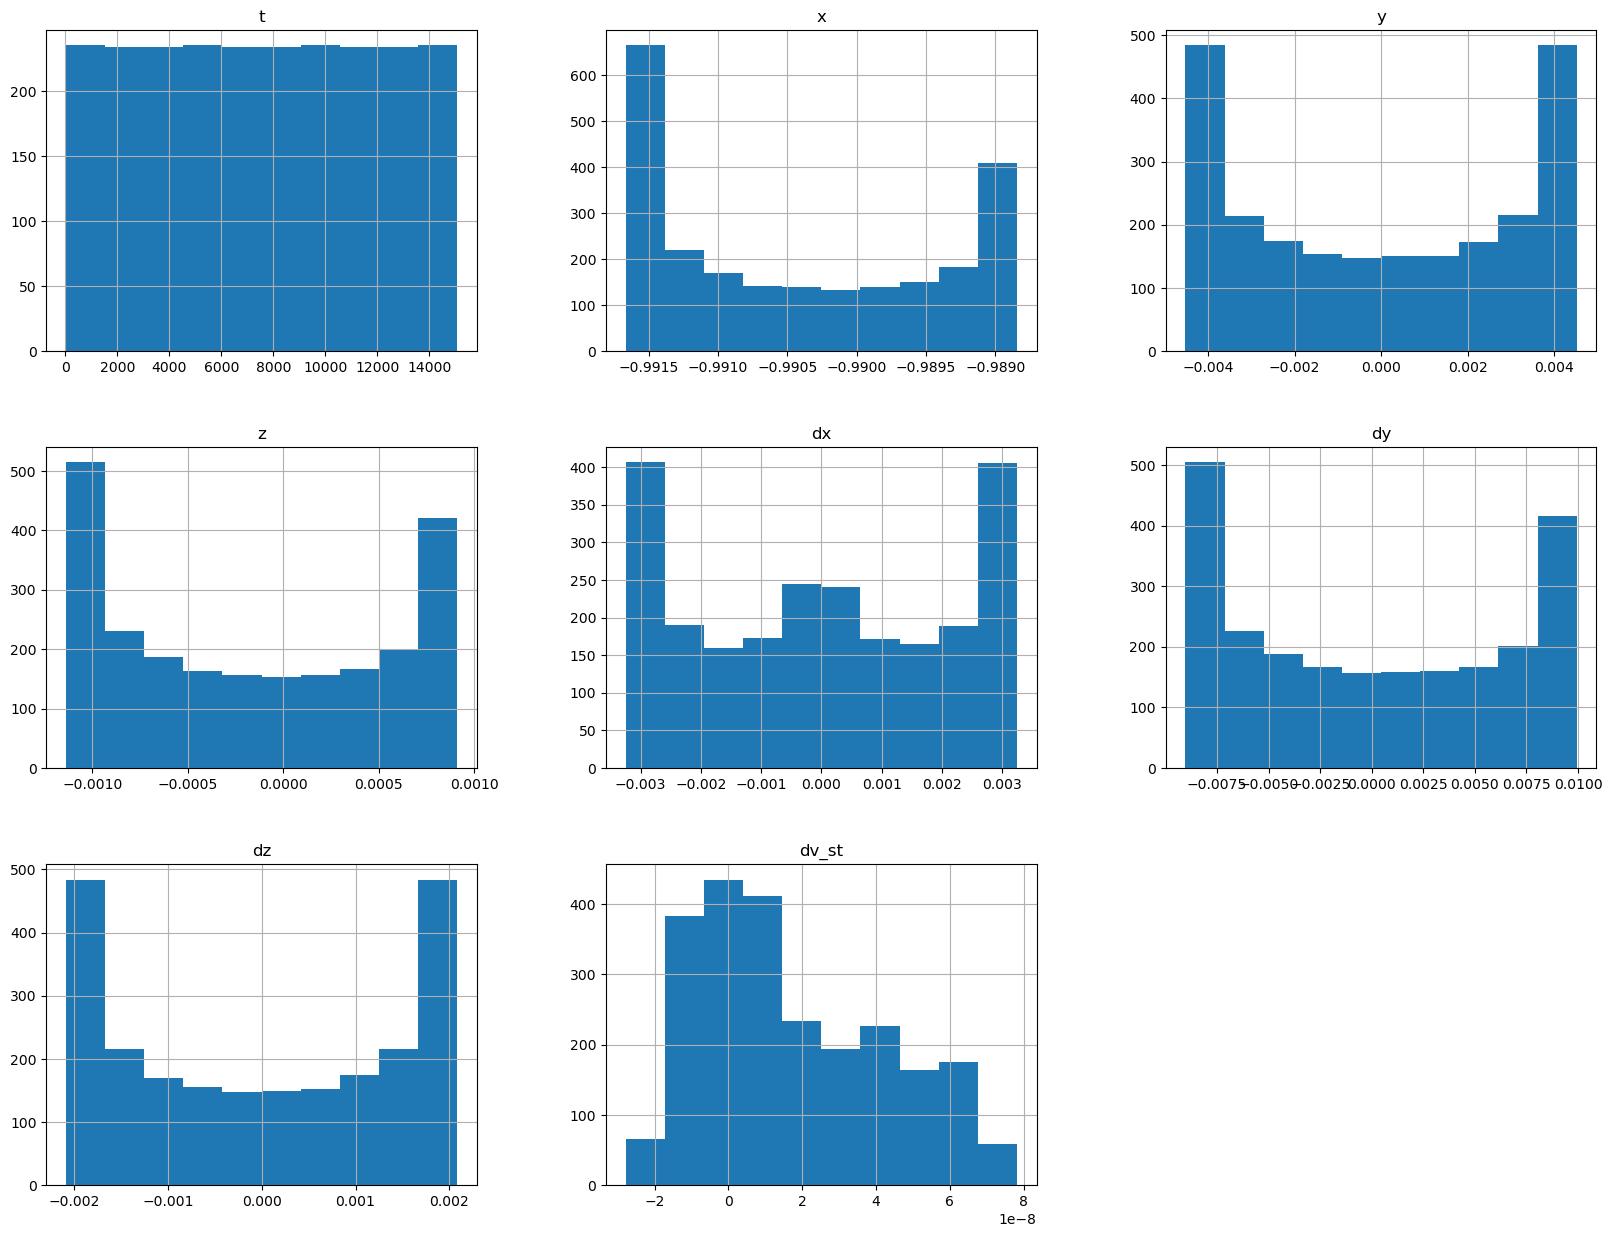

In [4]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Create a Train/Test Set

In [5]:
train_set, test_set = train_test_split(maneuvers, test_size=0.2, random_state=1)

## Visualizing Data

In [6]:
# Let's create a copy of the training set and call it 'maneuvers' again.
# This way we can play around with it without harming the training set.
maneuvers = train_set.copy()
maneuvers.size

15000

In [7]:
# Let's create a copy of the test set and call it 'maneuvers_test'.
# This way we can play around with it without harming the test set.
maneuvers_test = test_set.copy()
maneuvers_test.size

3752

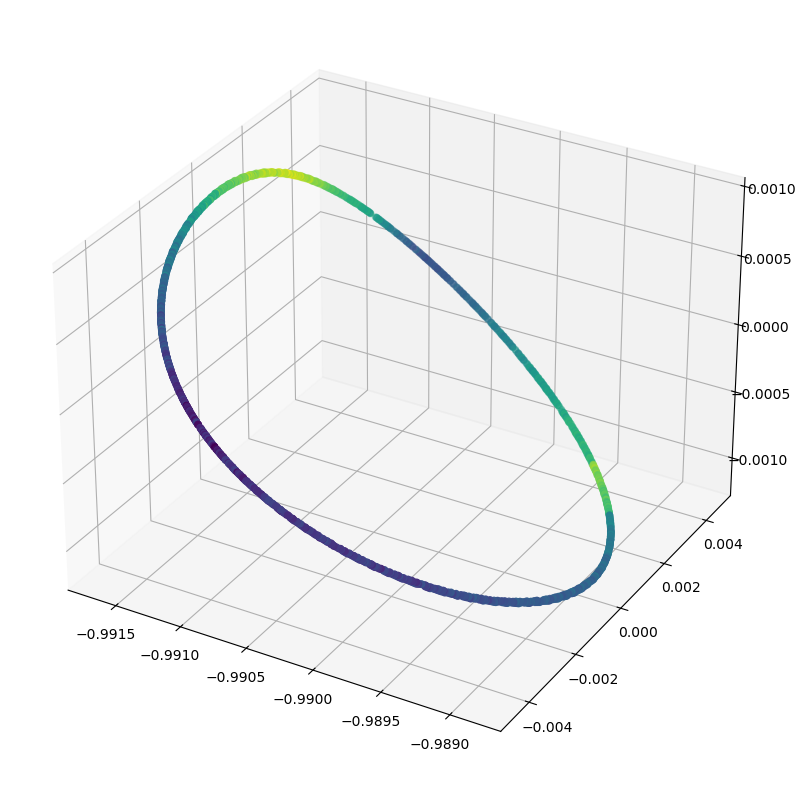

In [8]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [9]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
y        0.647522
dx       0.606075
z        0.334460
dy       0.332318
angle    0.037828
x       -0.253005
dz      -0.653383
Name: dv_st, dtype: float64

In [10]:
maneuvers_test["angle"]=maneuvers_test["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers_test = maneuvers_test.drop(["t"], axis=1)

array([[<Axes: xlabel='angle', ylabel='angle'>,
        <Axes: xlabel='x', ylabel='angle'>,
        <Axes: xlabel='dx', ylabel='angle'>,
        <Axes: xlabel='dv_st', ylabel='angle'>],
       [<Axes: xlabel='angle', ylabel='x'>,
        <Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='dx', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='angle', ylabel='dx'>,
        <Axes: xlabel='x', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='angle', ylabel='dv_st'>,
        <Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

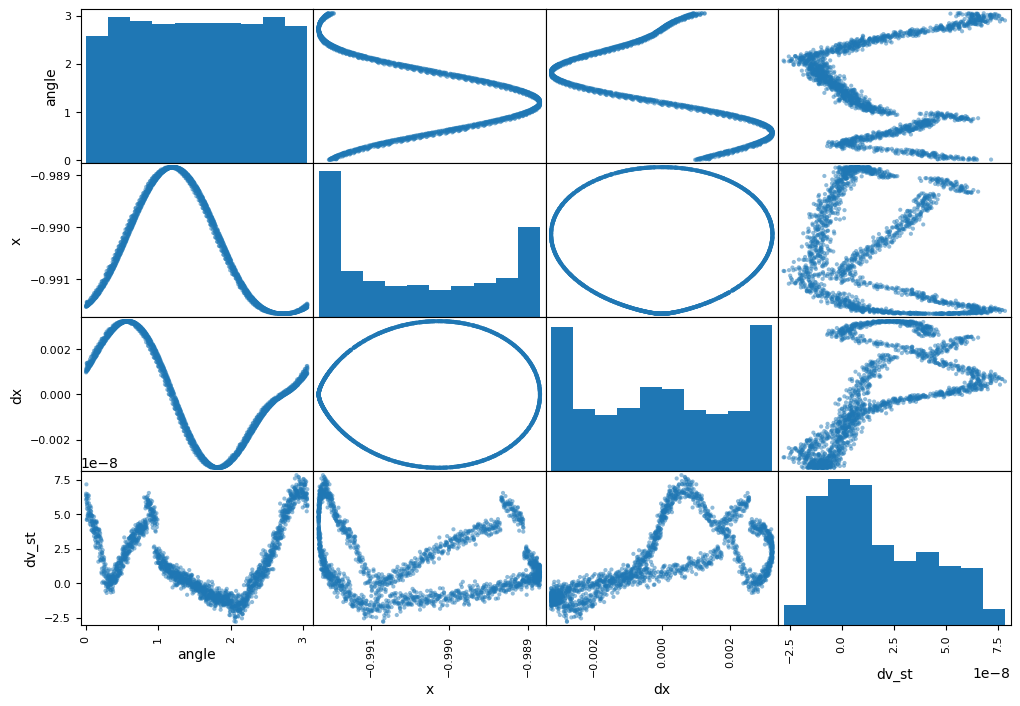

In [11]:
attributes = ["angle", "x", "dx", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Try Using Angle as the Single Descriptor

In [12]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers["angle"].copy()
maneuvers_predictors = maneuvers_predictors.array.reshape(-1,1)
maneuvers_labels = maneuvers["dv_st"].copy()
#print(maneuvers_predictors)

In [13]:
# Let's separate the predictors and the labels
maneuvers_test_predictors = maneuvers_test["angle"].copy()
maneuvers_test_predictors = maneuvers_test_predictors.array.reshape(-1,1)
maneuvers_test_labels = maneuvers_test["dv_st"].copy()

# Select and Train a Model

## Training and Evaluating on the Training Set

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(maneuvers_predictors, maneuvers_labels)

LinearRegression()

In [15]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(maneuvers_predictors)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.4926360002807597e-08

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [16]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = tree_reg.predict(maneuvers_predictors)
tree_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.2083120964758031e-08

NOW THIS IS MUCH BETTER!!

In [17]:
#Let's try it out on 5 instances from the test set
some_data = maneuvers_test_predictors[10:20]
some_labels = maneuvers_test_labels[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [-2.4106590565173735e-10, 5.80189482352941e-08, 4.4321687363636374e-08, 4.4321687363636374e-08, 4.4321687363636374e-08, 5.80189482352941e-08, 5.80189482352941e-08, 1.2086588252170545e-08, -2.4106590565173735e-10, 5.80189482352941e-08]
Labels: [5.369613e-09, 3.688208e-08, 4.273588e-08, 2.943253e-08, 3.50337e-08, 6.356831e-08, 4.877597e-08, 2.841401e-08, -1.117228e-08, 6.908756e-08]


In [18]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = forest_reg.predict(maneuvers_predictors)
forest_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.122588182742616e-08

## Polynomial Regression

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(maneuvers_predictors)
#print(maneuvers_predictors.head())
#print(maneuvers_pred_poly[0])

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, maneuvers_labels)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.802591486863788e-08

## SVM Regression

In [21]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(maneuvers_predictors, maneuvers_labels)
maneuvers_predictions = svm_poly_reg.predict(maneuvers_predictors)
svm_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

2.6211309952164352e-08

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [22]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, maneuvers_predictors, maneuvers_labels,
scoring="neg_root_mean_squared_error", cv=5)
tree_rmse_scores = -scores

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [1.27093531e-08 1.23416416e-08 1.12577090e-08 1.21506144e-08
 1.26734584e-08]
Mean: 1.2226555291532345e-08
Standard deviation: 5.273502034343276e-10
